# Load packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

# Load data

In [4]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Clean data

In [5]:
#Merge train and test data
train_test = pd.concat([train,test], axis=0)
train_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1046.0,NaN,NaN,NaN,29.881138,14.413493,0.17,21.0,28.0,39.0,80.0
SibSp,1309.0,NaN,NaN,NaN,0.498854,1.041658,0.0,0.0,0.0,1.0,8.0
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
Ticket,1309,929,CA. 2343,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308.0,NaN,NaN,NaN,33.295479,51.758668,0.0,7.8958,14.4542,31.275,512.3292


In [6]:
#Impute age based on title
train_test["Title"] = train_test["Name"].str.extract('([A-Za-z]+)\.')
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [7]:
train_test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [8]:
title_map = {'Don':'Mr',  
             'Major':'Mr', 
             'Sir':'Mr', 
             'Col':'Mr', 
             'Capt':'Mr', 
             'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'Countess':'Mrs',
            'Dona':'Mrs',
            'Ms':'Miss',
            'Mlle':'Miss'}
train_test['Title'] = train_test['Title'].map(title_map).fillna(train_test['Title'])

In [9]:
train_test['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Dr          8
Rev         8
Name: Title, dtype: int64

In [10]:
title_ages = dict(train_test.groupby('Title')['Age'].median())
title_ages

{'Dr': 49.0, 'Master': 4.0, 'Miss': 22.0, 'Mr': 30.0, 'Mrs': 35.5, 'Rev': 41.5}

In [11]:
train_test['Age'] = train_test['Age'].fillna(train_test['Title'].map(title_ages))

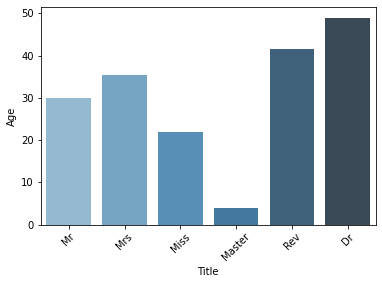

In [12]:
sns.barplot(x='Title', y='Age', data=train_test, estimator=np.median, ci=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

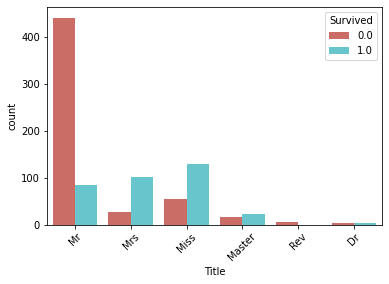

In [13]:
sns.countplot(x='Title', data=train_test, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [12]:
#Impute missing fares based on median fare by class
class_fares = dict(train_test.groupby('Pclass')['Fare'].median())

In [13]:
train_test['Fare'] = train_test['Fare'].fillna(train_test['Pclass'].map(class_fares))


In [14]:
#Impute missing embarked data by using backfill
train_test['Embarked'].fillna(method='backfill', inplace=True)

In [32]:
train_test['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [15]:
#Create new column "Family_Size" by combining Parch and SibSp
train_test['Family_Size'] = train_test['Parch'] + train_test['SibSp']

In [18]:
train_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
SibSp,1309.0,NaN,NaN,NaN,0.498854,1.041658,0.0,0.0,0.0,1.0,8.0
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
Ticket,1309,929,CA. 2343,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292


In [19]:
#Drop unnecessary columns
train_test.drop(columns = ['Ticket','Cabin','Name','PassengerId'])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,1
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,male,30.0,0,0,8.0500,S,Mr,0
414,NaN,1,female,39.0,0,0,108.9000,C,Mrs,0
415,NaN,3,male,38.5,0,0,7.2500,S,Mr,0
416,NaN,3,male,30.0,0,0,8.0500,S,Mr,0


In [20]:
#Create training and testing datasets
X_train = train_test[pd.notnull(train_test['Survived'])].drop(['Survived'], axis=1)
y_train = train_test[pd.notnull(train_test['Survived'])]['Survived']
X_test = train_test[pd.isnull(train_test['Survived'])].drop(['Survived'], axis=1)

In [21]:
#Scale data
num_cols = ['Age','Fare','Parch','SibSp','Pclass','Family_Size']
cat_cols = ['Sex','Embarked','Title']

preprocessor = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(), cat_cols)
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

print(X_train.shape)

# Build and train model

In [24]:
input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.Dense(8, activation='relu'),
    #layers.Dense(2, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

#, kernel_regularizer=regularizers.l2(0.01)

In [25]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.2, 
    epochs=200,
    callbacks=[early_stopping],
    verbose=1
)

#validation_data=(X_valid, y_valid),

Epoch 1/200
23/23 [==============================] - 1s 27ms/step - loss: 0.7631 - accuracy: 0.4175 - val_loss: 0.7368 - val_accuracy: 0.4078
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7381 - accuracy: 0.4643 - val_loss: 0.7020 - val_accuracy: 0.4525
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5705 - val_loss: 0.6750 - val_accuracy: 0.6592
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.6113 - val_loss: 0.6498 - val_accuracy: 0.7263
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6882 - val_loss: 0.6238 - val_accuracy: 0.7542
Epoch 6/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.7180 - val_loss: 0.5980 - val_accuracy: 0.7877
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.7423 - val_loss: 0.5736 - val_accuracy: 0.7989
Epoch 8/200


In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 144       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None


# Measure performance

In [27]:
val_acc = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 85.80%


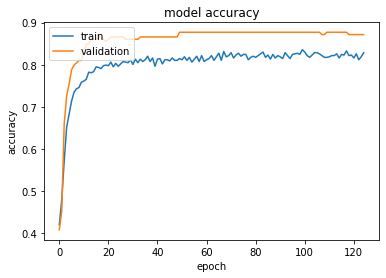

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Make prediction on test set

In [29]:
# calculate predictions
test['Survived'] = model.predict(X_test)
test['Survived'] = test['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = test[['PassengerId', 'Survived']]

In [30]:
solution.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [31]:
solution.to_csv("titanic_solution.csv", index=False)